In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [3]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        
        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [4]:

# Create the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 99:
            print(f'Loss: {running_loss/100:.3f} | Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0

# Test function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n')
    return accuracy


In [5]:

# Training loop
epochs = 5
accuracies2 = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}')
    print('-' * 10)
    train_epoch(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    accuracies.append(accuracy)



Epoch 1
----------
Loss: 0.564 | Acc: 83.31%
Loss: 0.150 | Acc: 89.38%
Loss: 0.115 | Acc: 91.73%
Loss: 0.101 | Acc: 93.13%
Loss: 0.069 | Acc: 94.07%
Loss: 0.081 | Acc: 94.67%
Loss: 0.065 | Acc: 95.16%
Loss: 0.061 | Acc: 95.54%
Loss: 0.062 | Acc: 95.82%

Test set: Average loss: 0.0576, Accuracy: 98.27%


Epoch 2
----------
Loss: 0.049 | Acc: 98.47%
Loss: 0.051 | Acc: 98.48%
Loss: 0.041 | Acc: 98.56%
Loss: 0.040 | Acc: 98.63%
Loss: 0.044 | Acc: 98.62%
Loss: 0.043 | Acc: 98.63%
Loss: 0.038 | Acc: 98.66%
Loss: 0.040 | Acc: 98.67%
Loss: 0.035 | Acc: 98.69%

Test set: Average loss: 0.0360, Accuracy: 98.81%


Epoch 3
----------
Loss: 0.023 | Acc: 99.16%
Loss: 0.029 | Acc: 99.07%
Loss: 0.031 | Acc: 99.03%
Loss: 0.028 | Acc: 99.07%
Loss: 0.031 | Acc: 99.05%
Loss: 0.032 | Acc: 99.04%
Loss: 0.030 | Acc: 99.04%
Loss: 0.036 | Acc: 99.04%
Loss: 0.028 | Acc: 99.04%

Test set: Average loss: 0.0271, Accuracy: 99.08%


Epoch 4
----------
Loss: 0.014 | Acc: 99.64%
Loss: 0.016 | Acc: 99.52%
Loss: 0.023 |

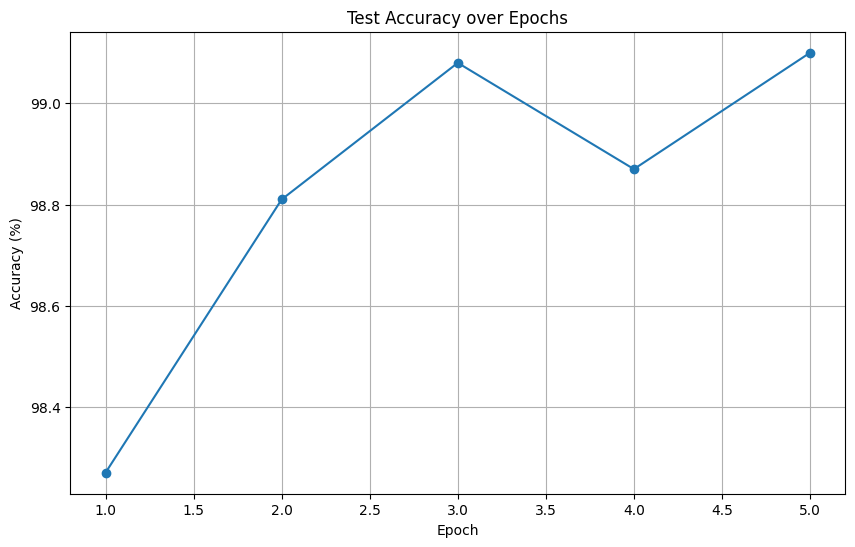

In [6]:
# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


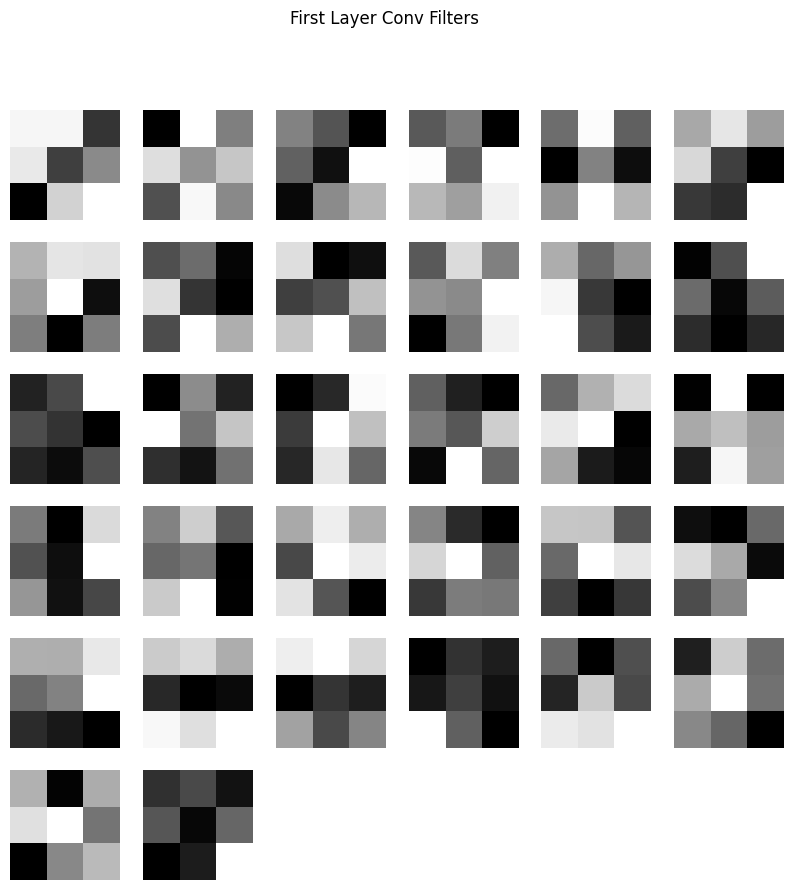

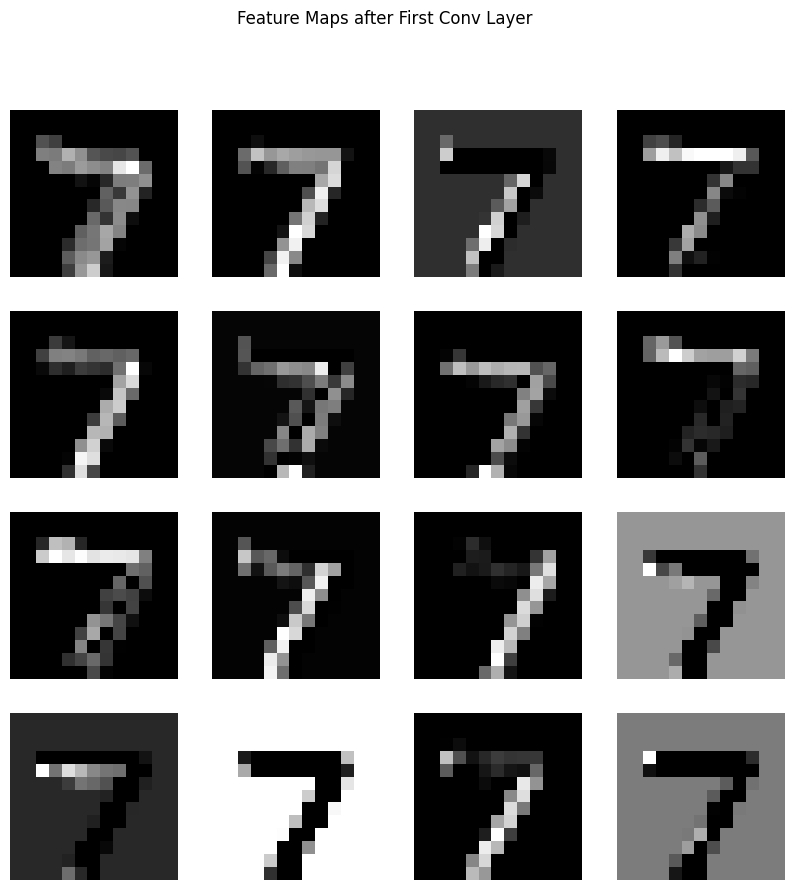

In [7]:


# Function to visualize filters
def visualize_filters(model, layer_idx=0):
    # Get the weights from the first convolutional layer
    weights = model.conv1.weight.data.numpy()
    
    # Create a figure with subplots for each filter
    plt.figure(figsize=(10, 10))
    for i in range(min(32, weights.shape[0])):
        plt.subplot(6, 6, i+1)
        plt.imshow(weights[i, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle('First Layer Conv Filters')
    plt.show()

# Visualize the filters
visualize_filters(model)

# Function to visualize feature maps
def visualize_feature_maps(model, input_image):
    model.eval()
    with torch.no_grad():
        # Get feature maps from first conv layer
        x = model.conv1(input_image)
        x = model.pool1(x)
        x = model.relu1(x)
        
        # Plot first 16 feature maps
        plt.figure(figsize=(10, 10))
        for i in range(min(16, x.shape[1])):
            plt.subplot(4, 4, i+1)
            plt.imshow(x[0, i].numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle('Feature Maps after First Conv Layer')
        plt.show()

# Get a sample image
sample_image, _ = next(iter(test_loader))
visualize_feature_maps(model, sample_image[0:1])

# Each small image shows how a different convolutional filter responds to an input digit 7. 
# Some focus on the main diagonal stroke
# Others pick up on the horizontal top line
# Some seem to detect the overall shape
# Different filters show varying levels of activation (brightness) for different parts of the digit

# Study Questions:

## Architecture Analysis:

### Why do we use MaxPool2d after the convolutional layers? What would happen if we removed them?

ans: MaxPool2d reduces spatial dimensions, making computation more efficient and providing some translation invariance. **Look at the last cell...**

Removing it seems to have the model not learning anything and just randomly guessing the digit. an accuracy of what youd expect, 1 in 10. 

## Training Process: ##

### What is the purpose of model.train() and model.eval()? Why do we need both?

ans: train() enables gradient computation and dropout; eval() disables them for testing. This affects batch normalization and dropout behavior. 


### How does the batch size affect training? What would happen if you used a very small or very large batch size?

ans: Larger batch sizes give more stable gradients but use more memory. Smaller batches add noise which can help escape local minima.

### Why do we zero the gradients (optimizer.zero_grad()) in each training iteration?

ans: Gradients accumulate by default in PyTorch - not zeroing them would incorrectly add gradients from previous batches.


## Model Performance:

### Look at the accuracy plot over epochs. Is the model still improving? 
How would you decide when to stop training?

ans: when the accuracy starts going down and doesn't recover. I would look at the graph and try to cut my losses in the epochs before that trend takes a downward turn  Is there a way to know for sure I'm not in a local minimum?

# From Claude in response to my answer here:
`You've got the right basic intuition about stopping when accuracy declines, but let's refine this understanding:
What you're describing is actually one form of early stopping, but there are a few important nuances:`
### Training vs Validation Accuracy:
`You need to monitor BOTH training and validation accuracy
If validation accuracy decreases while training accuracy keeps improving, that's a clear sign of overfitting
You want to stop at the point where validation performance peaks before overfitting begins`
### Local Minima vs Global Picture:
`To address your question about local minima: Yes, there are several techniques to help ensure you're not stuck in a local minimum:
Use multiple random initializations and compare results
Implement learning rate scheduling (like cosine annealing)
Add small amounts of noise to the gradients
Use optimizers like Adam that help escape local minima`
### Better Stopping Criteria:
`Instead of just looking for decreasing accuracy, use:
Patience parameter: Wait N epochs to see if performance improves
Rolling average: Look at trend over several epochs rather than individual points
Validation loss AND accuracy together
Delta minimum: Only stop if improvement is less than some threshold`
### Cross-Validation:
`K-fold cross-validation can help verify if what looks like "getting worse" is actually just noise in the validation set`

### What is the final accuracy of your model? How does it compare to human performance on MNIST?

ans: MNIST models typically achieve 98-99% accuracy, mine achieved 99.01% here. Humans achieve about 98%.



In [23]:


#I've commented out maxpool to answer question 1
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        #self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        #self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        # Fully connected layers
        # Fully connected layers
        # Note: We need to adjust this size since we're not pooling!
        self.fc1 = nn.Linear(64 * 24 * 24, 128)  # Changed from 64 * 5 * 5
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
       # x = self.pool1(x)
        x = self.relu1(x)
        
        # Layer 2
        x = self.conv2(x)
       # x = self.pool2(x)
        x = self.relu2(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [19]:

# Create the model
model2 = SimpleCNN2()
accuracies2 = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}')
    print('-' * 10)
    train_epoch(model2, train_loader, criterion, optimizer)
    accuracy2 = test(model2, test_loader)
    accuracies2.append(accuracy2)




Epoch 1
----------
Loss: 2.301 | Acc: 9.98%
Loss: 2.303 | Acc: 9.73%
Loss: 2.304 | Acc: 9.59%
Loss: 2.304 | Acc: 9.45%
Loss: 2.304 | Acc: 9.41%
Loss: 2.304 | Acc: 9.43%
Loss: 2.302 | Acc: 9.47%
Loss: 2.304 | Acc: 9.49%
Loss: 2.303 | Acc: 9.58%

Test set: Average loss: 2.3024, Accuracy: 10.04%


Epoch 2
----------
Loss: 2.305 | Acc: 9.39%
Loss: 2.303 | Acc: 9.67%
Loss: 2.303 | Acc: 9.46%
Loss: 2.303 | Acc: 9.71%
Loss: 2.303 | Acc: 9.71%
Loss: 2.302 | Acc: 9.65%
Loss: 2.304 | Acc: 9.62%
Loss: 2.304 | Acc: 9.65%
Loss: 2.303 | Acc: 9.61%

Test set: Average loss: 2.3024, Accuracy: 10.04%


Epoch 3
----------
Loss: 2.303 | Acc: 9.91%
Loss: 2.302 | Acc: 9.70%
Loss: 2.304 | Acc: 9.58%
Loss: 2.303 | Acc: 9.56%
Loss: 2.303 | Acc: 9.66%
Loss: 2.303 | Acc: 9.66%
Loss: 2.304 | Acc: 9.62%
Loss: 2.305 | Acc: 9.61%
Loss: 2.303 | Acc: 9.60%

Test set: Average loss: 2.3024, Accuracy: 10.04%


Epoch 4
----------
Loss: 2.302 | Acc: 9.61%
Loss: 2.302 | Acc: 9.88%
Loss: 2.304 | Acc: 9.86%
Loss: 2.303 | Acc

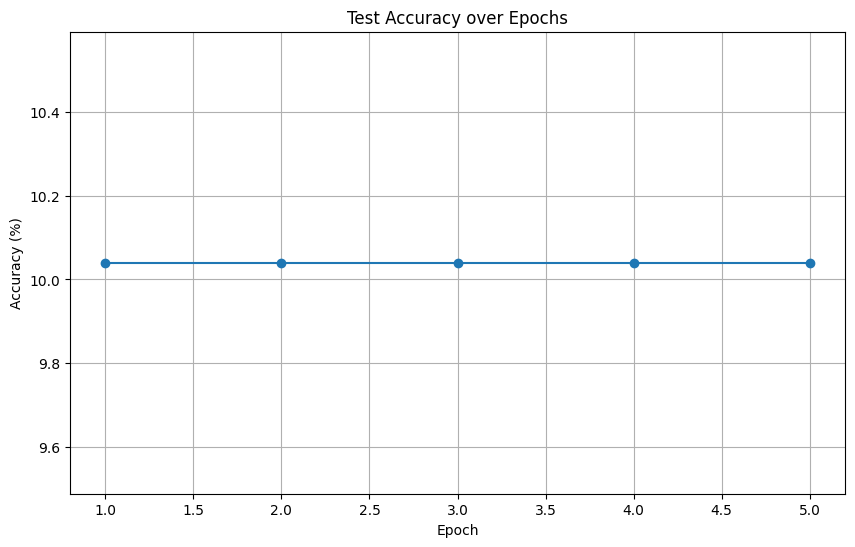

In [22]:
# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracies2, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

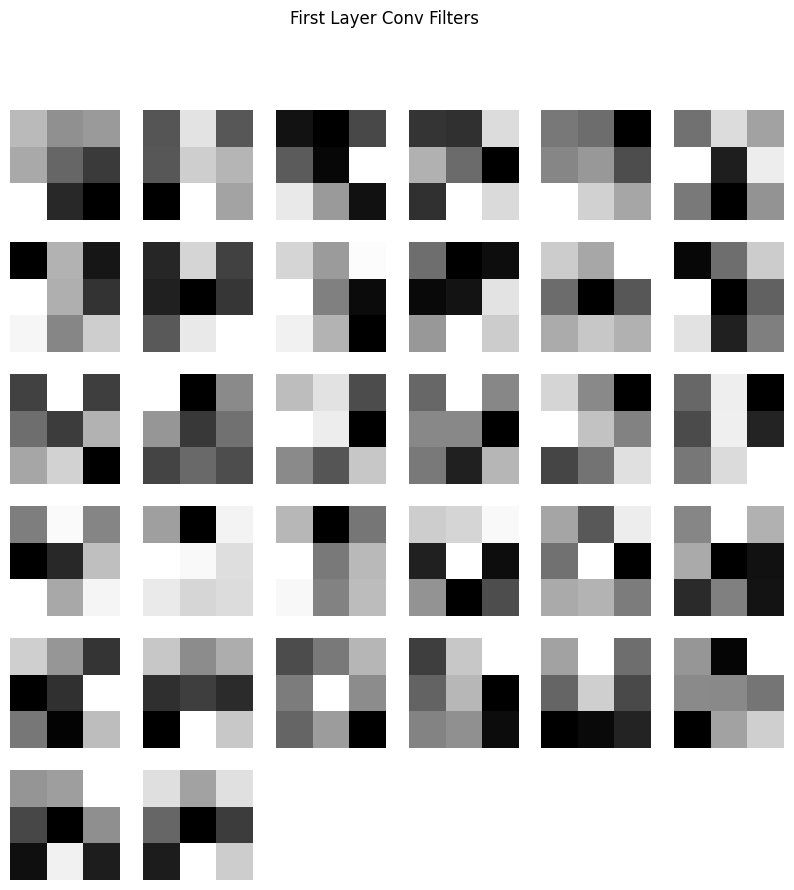

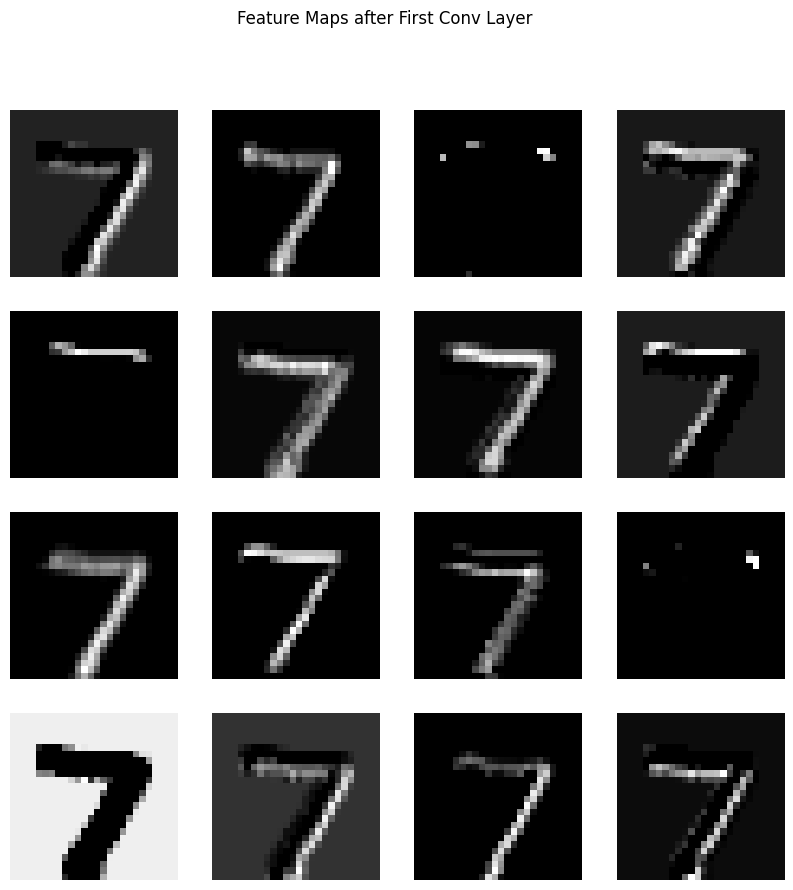

In [27]:
visualize_filters(model2)

def visualize_feature_maps2(model, input_image):
    model.eval()
    with torch.no_grad():
        # Get feature maps from first conv layer
        x = model.conv1(input_image)
        #x = model.pool1(x)
        x = model.relu1(x)
        
        # Plot first 16 feature maps
        plt.figure(figsize=(10, 10))
        for i in range(min(16, x.shape[1])):
            plt.subplot(4, 4, i+1)
            plt.imshow(x[0, i].numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle('Feature Maps after First Conv Layer')
        plt.show()
        sample_image, _ = next(iter(test_loader))

visualize_feature_maps2(model2, sample_image[0:1])